In [ ]:
# !pip install cloud-tpu-client
# !pip install torch-xla torch-xla-core


In [ ]:
use_dolfinx = False

### colab

In [ ]:
import os
colab = os.getcwd() == "/content"
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### import

In [ ]:
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx

In [ ]:
if colab:
    if use_dolfinx:
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

In [ ]:
# !mpirun --allow-run-as-root --map-by slot:OVERSUBSCRIBE -np 4 python3 ns_dolfinx.py


In [ ]:
from __future__ import print_function


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc

        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        gmsh.initialize()

<ipython-input-9-4c9dc3b6c8b1>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


In [ ]:
from IPython.display import clear_output as clc

plt.style.use("default")


In [ ]:
if colab:
    if use_dolfinx:
        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

In [ ]:
from scipy.interpolate import RBFInterpolator

In [ ]:
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [ ]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [ ]:
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [ ]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

# Parameters

In [ ]:
L = 10
H = 4
# N_points = 121  # numero di punti per la discretizzazione dell'airfoil
chord = 1

# Airfoil parameters
chord = 1  # Adjust as needed
Aoa = 20
# N_points = 121
# c_x, c_y = 0.2 * L + 0.5 * chord, H / 2
x_le, y_le = 0.3 * L, 0.5 * H

if colab:
    if use_dolfinx:
        mesh_comm = MPI.COMM_WORLD
        model_rank = 0
        gdim = 2

# Physical and discretization parameters
t = 0
T = 10 # Final time
dt = 0.05  # Time step size
timesteps = int(T / dt)
mu_ = 0.01
rho_ = 1
U_max = 1.5
Re = (U_max * 2 / 3) * chord * rho_ / mu_
print(f"Re: {Re:.2f}")

save_numpy_unsteady = True
save_to_np_every_steps = 1
# save_to_torch_every_steps = 1
save_to_np_every_steps = 1

Re: 100.00


# Mesh generation

In [ ]:
# # Mesh parameters
# # res_min = 0.001 # minima grandezza elementi vicino bordo ostacolo
# res_min = 0.01
# LcMin = res_min
# LcMax = 0.05 * H # massima grandezza elementi vicino bordi della mesh
# # LcMax = 0.1 * H
# DistMin = res_min * 3 # distanza dall'ostacolo in cui inizia il grading
# DistMax = H # distanza dall'ostacolo in cui finisce il grading

# # altre modifiche in generating the mesh
# # res_min_wake = 0.005
# res_min_wake = 0.05
# LcMax_wake = 0.05 * H
# DistMin_wake = res_min_wake * 3
# DistMax_wake = H

# Fine mesh
# generate_fine_mesh = True
# write_fine_mesh = False
# save_fine_mesh_numpy = True

# lref = f"cl{chord}_Aoa{Aoa}"
# name = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}"
# name_unsteady = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}_dt{dt}"
# name_mesh = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}"
# write_mesh = False
# save_mesh_numpy = True
# write_stokes = False
# write_ns = False
# write_ns_unsteady = False
# save_numpy = False

In [ ]:
# airfoil_coords = generate_airfoil(0, 0.4, 0.12, N_points) # NACA 0012
# # mesh = generate_airfoil_mesh(base_pts, L, H, ref = 128)

# ntrajectories = 1
# nparams = 2 + 11 # physical + airfoil

In [ ]:
# x_airfoil, y_airfoil = (airfoil_coords[:, 0] + x_le).tolist(), (airfoil_coords[:, 1] + y_le).tolist()

In [ ]:
# # if mesh_comm.rank == model_rank:
#     # Create rectangle domain
# rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)

In [ ]:
# points = []
# for i in range(len(x_airfoil)):
#     point = gmsh.model.occ.addPoint(x_airfoil[i], y_airfoil[i], 0)
#     points.append(point)
# points.append(points[0])
# spline = gmsh.model.occ.addSpline(points)
# # line_last_first = gmsh.model.occ.addLine(points[-1], points[0])
# # airfoil_curve = gmsh.model.occ.addCurveLoop([spline, line_last_first])
# airfoil_curve = gmsh.model.occ.addCurveLoop([spline])
# obstacle = gmsh.model.occ.addPlaneSurface([airfoil_curve])

In [ ]:
# p1 = gmsh.model.occ.addPoint(x_le + chord + 0.01, y_le, 0)
# p2 = gmsh.model.occ.addPoint(L, H / 2, 0)
# horizontal_line = gmsh.model.occ.addLine(p1, p2)
# gmsh.model.occ.synchronize()

In [ ]:
# fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
# gmsh.model.occ.synchronize()

In [ ]:
# fluid_marker = 1
# # if mesh_comm.rank == model_rank:
# # Add physical volume marker
# volumes = gmsh.model.getEntities(dim=gdim)
# assert len(volumes) == 1
# gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
# gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

In [ ]:
# inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
# inflow, outflow, walls, obstacle = [], [], [], []
# # if mesh_comm.rank == model_rank:
# boundaries = gmsh.model.getBoundary(volumes, oriented=False)
# for boundary in boundaries:
#     center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
#     if np.allclose(center_of_mass, [0, H / 2, 0]):
#         inflow.append(boundary[1])
#     elif np.allclose(center_of_mass, [L, H / 2, 0]):
#         outflow.append(boundary[1])
#     elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(
#         center_of_mass, [L / 2, 0, 0]
#     ):
#         walls.append(boundary[1])
#     else:
#         obstacle.append(boundary[1])
# gmsh.model.addPhysicalGroup(1, walls, wall_marker)
# gmsh.model.setPhysicalName(1, wall_marker, "Walls")
# gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
# gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
# gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
# gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
# gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
# gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In [ ]:
# # res_min = 0.001
# # if mesh_comm.rank == model_rank:

# # Mesh Refinement con transfinite e grading
# distance_field = gmsh.model.mesh.field.add("Distance")
# gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)

# grading_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
# gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
# gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
# gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
# gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)
# # final_field = gmsh.model.mesh.field.add("Min")
# # gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field])
# # gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# # Wake refinement
# horizontal_line_field = gmsh.model.mesh.field.add("Distance")
# gmsh.model.mesh.field.setNumbers(horizontal_line_field, "EdgesList", [horizontal_line])
# horizontal_refine_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "IField", horizontal_line_field)
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMin", res_min_wake)  # dimensione minima vicino alla linea
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMax", LcMax_wake)    # dimensione massima lontano dalla linea
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMin", DistMin_wake)  # distanza entro cui applicare LcMin
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMax", DistMax_wake)  # distanza oltre cui applicare LcMax

# final_field = gmsh.model.mesh.field.add("Min")
# gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, horizontal_refine_field])
# gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# # Impostazioni avanzate per la mesh
# gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
# # gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)  # Quadrangolazione
# gmsh.option.setNumber("Mesh.RecombineAll", 0)
# # gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)  # Maggiore regolarità

# # Generazione e ottimizzazione
# gmsh.model.mesh.generate(gdim)
# gmsh.model.mesh.setOrder(1)
# # gmsh.model.mesh.optimize("HighOrder")

# # Salva la mesh
# # gmsh.write("airfoil_mesh.msh")
# # gmsh.finalize()

In [ ]:
# # if mesh_comm.rank == model_rank:
# quality = gmsh.model.mesh.getNodes()
# print(f"Generated {len(quality[0])} nodes.")


In [ ]:
# mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
# ft = facet_tags
# ft.name = "Facet markers"
# cell_tags.name = "Cell markers"

In [ ]:
# # # Get mesh topology and geometry
# topology, cell_types, geometry = dolfinx.plot.vtk_mesh(mesh, mesh.topology.dim)

In [ ]:
# with dolfinx.io.XDMFFile(mesh.comm, "mesh.xdmf", "w") as xdmf:
#     xdmf.write_mesh(mesh)
#     xdmf.write_meshtags(ft, mesh.geometry)


In [ ]:
# gmsh.write("naca0012_mesh.msh")

# Utilities

In [ ]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [ ]:
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))


In [ ]:
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [ ]:
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [ ]:
def interpolate_mesh(mesh, control_points, displacements):
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q = functionspace(mesh, s_cg1)
    mesh_coords = np.array(Q.tabulate_dof_coordinates())

    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(mesh_coords[:, :2])
    mesh.geometry.x[:, :2] = mesh_coords[:, :2] + displacements

    return mesh

In [ ]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [ ]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    # print(N_points)
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    # print(airfoil_control_points_ids.shape)
    # print(airfoil_control_points_ids)
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [ ]:
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # U_max * np.sin(self.t * np.pi / 8)
            U_max * np.cos(self.alpha)
        )
        values[1] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # 4 * U_max * x[1] * (H - x[1]) / (H**2)
            4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.sin(self.alpha)
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha):

    fdim = mesh.topology.dim - 1

    # Define boundary conditions
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker))
    )

    # Walls
    # # nonslip
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    # bcu_walls = dirichletbc(
    #     u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V
    # )
    # freeslip
    walls_dofs_y = locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, ft.find(wall_marker))
    bcu_walls = dirichletbc(dolfinx.default_scalar_type(0), walls_dofs_y, V.sub(1))

    # Obstacle
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )
    bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

    # Outlet
    bcp_outlet = dirichletbc(
        PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q
    )
    bcp = [bcp_outlet]

    return bcu, bcp, u_inlet, inlet_velocity

In [ ]:
def solve(params, mesh, facet_tags, dt, num_steps, mu_, rho_, save_to_np_every_steps = 10):

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    U_max_0 = params[1][0]
    alpha_0 = params[0][0]
    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max_0, alpha_0)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(mu_))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    # F1_SUPG = F1 + tau_supg * dot(residual_momentum, v) * dx
    # a1 = form(lhs(F1_SUPG))
    # L1 = form(rhs(F1_SUPG))
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.LU)
    pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
    solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.LU)
    pc2.setFactorSolverType("mumps")
    solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.LU)
    pc3.setFactorSolverType("mumps")
    solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns_unsteady = Function(Q_vectorial)
    u_ns_unsteady.interpolate(u_)
    # newshape_ = (u_ns_unsteady.x.array[:].shape[0]//2, 2)
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, newshape = newshape_))
    U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))

    u_np = np.zeros_like(U[:, 0].reshape(1, -1))
    v_np = np.zeros_like(U[:, 1].reshape(1, -1))
    p_np = np.zeros_like(p_.x.array).reshape(1, -1)
    # u_mag_np = np.sqrt(u_np**2 + v_np**2)

    # u_torch = torch.zeros_like(U[:, 0]).reshape(1, -1)
    # v_torch = torch.zeros_like(U[:, 1]).reshape(1, -1)
    # p_torch = torch.zeros_like(torch.tensor(p_.x.array)).reshape(1, -1)

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0
    for i in range(num_steps):

        progress.update(1)

        # Update current time step
        t += dt

        print(f"timestep {i+1}, time {t}", ", ||u||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((u_)**2 * dx)), MPI.SUM)),
              ", ||p||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((p_)**2 * dx)), MPI.SUM)))

        # Update inlet velocity
        # inlet_velocity.t = t
        inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()

        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # clc(wait = True)

        # if save_numpy_unsteady:
        if i % save_to_np_every_steps == 0:
            # Save to np
            u_ns_unsteady.interpolate(u_)
            U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
            u_np = np.concatenate((u_np, U[:, 0].reshape(1, -1)), 0)
            v_np = np.concatenate((v_np, U[:, 1].reshape(1, -1)), 0)
            p_np = np.concatenate((p_np, p_.x.array.reshape(1, -1)), 0)
            # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # if i % save_to_torch_every_steps == 0:
        #     # Save to np
        #     u_ns_unsteady.interpolate(u_)
        #     U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))
        #     u_torch = torch.cat((u_torch, U[:, 0].reshape(1, -1)), 0)
        #     v_torch = torch.cat((v_torch, U[:, 1].reshape(1, -1)), 0)
        #     p_torch = torch.cat((p_torch, torch.tensor(p_.x.array.reshape(1, -1))), 0)
        #     # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # Update variable with solution form this time step
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

    progress.close()
    # return u_torch, v_torch, p_torch
    return u_np, v_np, p_np


# Snapshots generation

### Load NACA0012 mesh

In [ ]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

In [ ]:
# # Load naca0012 mesh
# gmsh.initialize()
# gmsh.open("naca0012_mesh.msh")

# mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
# ft = facet_tags
# [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker], [inlet_nodes, outlet_nodes, wall_nodes, obstacle_nodes] = get_markers_and_nodes()
# airfoil_coords = np.array(obstacle_nodes)
# N_points = airfoil_coords.shape[0]

# # if mesh_comm.rank == model_rank:
# quality = gmsh.model.mesh.getNodes()
# print(f"Mesh has {len(quality[0])} nodes.")

In [ ]:
# gmsh.finalize()

In [ ]:
# s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# naca0012_coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
# naca0012_airfoil_coords = copy.deepcopy(airfoil_coords)

In [ ]:
# np.savez("naca0012_data.npz", naca0012_airfoil_coords = naca0012_airfoil_coords, naca0012_coords = naca0012_coords)

In [ ]:
naca0012_data = np.load("data/naca0012_data.npz")
naca0012_coords = naca0012_data['naca0012_coords']
naca0012_airfoil_coords = naca0012_data['naca0012_airfoil_coords']

### Snapshots loop

In [ ]:
# ntrajectories = 100
# nparams = 2 + 3 # physical + airfoil
# # nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
# npressure = naca0012_coords.shape[0]
# ntimes = timesteps + 1 # initial condition

In [ ]:
# # generate new airfoil
# new_airfoil_coords = generate_airfoil_random(n_points = N_points, x_le = x_le, y_le = y_le)

# # control points
# control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)

# # Interpolate mesh on the new airfoil
# mesh = interpolate_mesh(mesh, control_points, displacements)


In [ ]:
# params_ph_range = [(-1.0, 1.0), (0.5, 2), ] # Physical parameters: angle of attack and inflow intensity
# params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.09 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
# params_range = params_ph_range + params_airfoil_range

# filename = 'FlowAroundAirfoil_data'
# # U = torch.zeros(ntrajectories, ntimes, npressure)
# # V = torch.zeros(ntrajectories, ntimes, npressure)
# # P = torch.zeros(ntrajectories, ntimes, npressure)
# # MU = torch.zeros(ntrajectories, ntimes, nparams)

# U = np.zeros((ntrajectories, ntimes, npressure))
# V = np.zeros((ntrajectories, ntimes, npressure))
# P = np.zeros((ntrajectories, ntimes, npressure))
# MU = np.zeros((ntrajectories, ntimes, nparams))

# airfoil_indices_list = []

# os.makedirs("snapshots", exist_ok=True)

# for i in range(ntrajectories):

#     print(f"Generating snapshot n.{i}...")

#     params = [0] * len(params_range)
#     for j in range(len(params_range)):
#         params[j] = ((params_range[j][1] - params_range[j][0]) * np.random.rand(1) + params_range[j][0]).item()
#     params = [[param_i] * ntimes for param_i in params] # shape (n_params, n_timesteps)

#     m_ = params[2][0]
#     p_ = params[3][0]
#     t_ = params[4][0]
#     new_pts = generate_airfoil(m_, p_, t_, N_points)

#     print("U_max : ", params[1][0], " [m/s]")
#     print("Aoa : ", params[0][0] * 180 / np.pi, " deg")
#     print("Re: ", params[1][0] * np.cos(params[0][0]) * chord  * rho_ / mu_)

#     # Interpolate mesh on new airfoil
#     new_airfoil_coords = generate_airfoil(m_, p_, t_, n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     mesh = interpolate_mesh(mesh, control_points, displacements)
#     airfoil_coords = new_airfoil_coords

#     # [ut, vt, pt] = compute_state(params, mesh, dt, nu, ntimesteps)
#     # [ut, vt, pt] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_torch_every_steps)
#     [u_np, v_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)

#     # U[i] = ut
#     # V[i] = vt
#     # P[i] = pt

#     U[i] = u_np
#     V[i] = v_np
#     P[i] = p_np

#     # for j, param_j in enumerate(params, 0):
#     #     MU[i, :, j] = torch.tensor(param_j)

#     for j, param_j in enumerate(params, 0):
#         MU[i, :, j] = np.array(param_j)

#     clc(wait = True)

#     # np.savez(f"snapshots/snapshot_{i}.npz", ut = ut, vt = vt, pt = pt, params = params)
#     np.savez(f"snapshots/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

# print("Snapshots generated!")

# # np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

### Plot

In [ ]:

# data = np.load("snapshots/snapshot_1.npz") -->
# u_np, v_np, p_np = data["u_np"], data["v_np"], data["p_np"]
# s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# Q = functionspace(mesh, s_cg1)
# coords = np.array(Q.tabulate_dof_coordinates())
# x, y = coords[:, 0], coords[:, 1]
# triang = tri.Triangulation(x, y)
# x_tri = x[triang.triangles].mean(axis=1)
# y_tri = y[triang.triangles].mean(axis=1)
# mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(airfoil_coords[:, 0], airfoil_coords[:, 1]))])
# triang.set_mask(mask)
# u = u_np.transpose()
# v = v_np.transpose()
# p = p_np.transpose()
# from matplotlib.animation import FuncAnimation, PillowWriter
# from matplotlib.cm import ScalarMappable
# import matplotlib.colors as mcolors

# # Calcola la magnitudine di u per tutti i timestep e determina min e max globali
# u_all = np.sqrt(u**2 + v**2)
# u_min, u_max = u_all.min(), u_all.max()
# p_min, p_max = np.delete(p, 1, axis=1).min(), np.delete(p, 1, axis=1).max()

# # Crea gli oggetti norm per fissare la scala dei colori
# norm_u = mcolors.Normalize(vmin=u_min, vmax=u_max)
# norm_p = mcolors.Normalize(vmin=p_min, vmax=p_max)

# # Crea due ScalarMappable per le colorbar statiche
# sm_u = ScalarMappable(cmap='jet', norm=norm_u)
# sm_u.set_array([])
# sm_p = ScalarMappable(cmap='jet', norm=norm_p)
# sm_p.set_array([])
# # Imposta la figura con 2 sottotrame
# scale = 2
# nrows = 1
# ncols = 2

# fig, ax = plt.subplots(nrows, ncols)
# # Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
# cbar_u = fig.colorbar(sm_u, ax=ax[0], orientation='horizontal', pad = 0.05, aspect = 30)
# ax[0].set_title("U (magnitudine)")
# cbar_p = fig.colorbar(sm_p, ax=ax[1], orientation='horizontal', pad = 0.05, aspect = 30)
# ax[1].set_title("p")

# # timestep a scelta
# time_to_plot = 0.5
# time_index = int(time_to_plot / dt)
# time_index_np = time_index // save_to_np_every_steps

# u_plot = u[:, time_index_np]
# v_plot = v[:, time_index_np]
# p_plot = p[:, time_index_np]

# u_mag = np.sqrt(u_plot**2 + v_plot**2)

# cont1 = ax[0].tricontourf(triang, u_mag, cmap="jet", levels=200, norm=norm_u)
# ax[0].set_aspect("equal")
# cont2 = ax[1].tricontourf(triang, p_plot, cmap="jet", levels=200, norm=norm_p)
# ax[1].set_aspect("equal")

# add_zoom(2)

# plt.show()

# import imageio

# # Crea cartella temporanea per i frame
# os.makedirs("frames", exist_ok=True)

# # Loop per creare i frame
# filenames = []

# for i in range(ntimes):

#     u_plot = u[:, i]
#     v_plot = v[:, i]  # Assumo che `v` esista
#     p_plot = p[:, i]

#     u_mag = np.sqrt(u_plot**2 + v_plot**2)

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#     cont1 = ax[0].tricontourf(triang, u_mag, cmap="jet", levels=200, norm=norm_u)
#     ax[0].set_title("U (magnitudine)")
#     ax[0].set_aspect("equal")
#     fig.colorbar(sm_u, ax=ax[0], orientation='horizontal', pad=0.05, aspect=30)
#     cont2 = ax[1].tricontourf(triang, p_plot, cmap="jet", levels=200, norm=norm_p)
#     ax[1].set_title("p")
#     ax[1].set_aspect("equal")
#     fig.colorbar(sm_p, ax=ax[1], orientation='horizontal', pad=0.05, aspect=30)

#     # Zoom opzionale
#     add_zoom(2)

#     filename = f"frames/frame_{i:04d}.png"
#     fig.savefig(filename)
#     filenames.append(filename)
#     plt.close(fig)

# # Crea la gif
# with imageio.get_writer("output.gif", mode='I', duration=0.1) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# # Pulizia (opzionale)
# for filename in filenames:
#     os.remove(filename)


# Generate trajectory coordinates

In [ ]:
# data = np.load("../my_SHRED-ROM/dataset.npz")

In [ ]:
# MU = data["MU"]
# del data

In [ ]:
# nvelocity = naca0012_coords.shape[0]
# ntrajectories, ntimes, nparams = MU.shape

In [ ]:
# def update_coords(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

#     N_points = airfoil_coords.shape[0]
#     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     coords = interpolate_coords(coords, control_points, displacements)

#     return coords

In [ ]:
# XY = np.zeros((ntrajectories, nvelocity, 2), dtype = np.float32)

In [ ]:
# for i in range(ntrajectories):
#     params = MU[i, 0, 2:]
#     XY[i, :, :] = update_coords(params)

In [ ]:
# np.savez_compressed("XY.npz", XY = XY)

In [ ]:
# scatter_array(XY[30], s = 0.1)
# add_zoom()

# Load Snapshots

In [ ]:
os.getcwd()
data = np.load("data/dataset.npz")
Vx = data["Vx"]
Vy = data["Vy"]
# P = torch.tensor(data["P"])
MU = data["MU"]

# ntrajectories, ntimes, npressure = Vx.numpy().shape
# nparams = MU.shape[2]
# del data
MU.shape
# # # Salvo solo metà del dataset
# id_constant = np.random.randint(low = 0, high = 100, size = 40)
# id_timedep = np.random.randint(low = 100, high = 200, size = 40)
# ids = id_constant.tolist() + id_timedep.tolist()
# # ids
XY = np.load("data/XY.npz")["XY"]
# Vx = Vx[ids]
# Vy = Vy[ids]
# MU = MU[ids]
# XY = XY[ids]
# np.savez_compressed("/content/dataset.npz", Vx = Vx[ids], Vy = Vy[ids], P = P[ids], MU = MU[ids])
# np.savez_compressed("/content/dataset.npz", Vx = Vx, Vy = Vy, P = P, MU = MU)

ntrajectories, ntimes, npressure = Vx.shape
nparams = MU.shape[2]
nvelocity = npressure

In [ ]:
m_vals = np.sort(MU[:, 0, 2])
p_vals = np.sort(MU[:, 0, 3])
t_vals = np.sort(MU[:, 0, 4])
alpha_vals = np.sort(MU[:, 0, 0])
uin_vals = np.sort(MU[:, 0, 1])

In [ ]:
# Indici degli elementi ordinati in ordine crescente
sorted_indices_alpha_vals = np.argsort(MU[:, 0, 0])

ntest = np.round(0.1 * ntrajectories)
bottomk_indices_alpha = sorted_indices_alpha_vals[:ntest//2]
topk_indices_alpha = sorted_indices_alpha_vals[-ntest//2:][::-1]

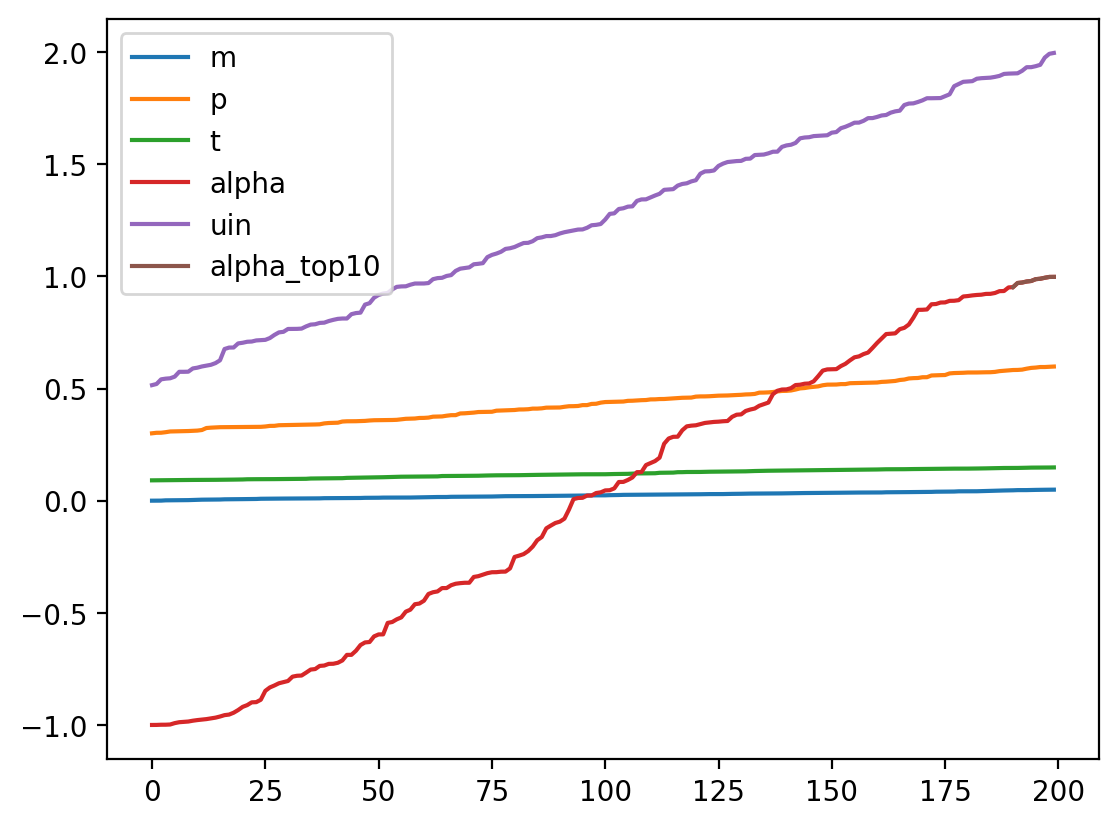

In [ ]:
plt.plot(np.arange(len(m_vals)), m_vals, label = "m")
plt.plot(np.arange(len(m_vals)), p_vals, label = "p")
plt.plot(np.arange(len(m_vals)), t_vals, label = "t")
plt.plot(np.arange(len(m_vals)), alpha_vals, label = "alpha")
plt.plot(np.arange(len(m_vals)), uin_vals, label = "uin")
plt.plot(np.arange(len(m_vals)-10, len(m_vals)), np.sort(MU[topk_indices_alpha, 0, 0]), label = "alpha_top10")
plt.legend()
plt.show()

In [ ]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed = 0
ntrain = round(0.8 * ntrajectories)

# del data
# data = np.load("data/data.npz")
# idx_train = torch.from_numpy(data["idx_train"])
# idx_valid = torch.from_numpy(data["idx_valid"])
# idx_test = torch.from_numpy(data["idx_test"])

sorted_indices_alpha_vals = np.argsort(MU[:, 0, 0])

ntest = np.round(0.1 * ntrajectories)
k = int(ntest//2)
bottomk_indices_alpha = sorted_indices_alpha_vals[:k]
topk_indices_alpha = sorted_indices_alpha_vals[-k:][::-1]
idx_test = np.concatenate((bottomk_indices_alpha, topk_indices_alpha), 0)
# Indici rimanenti
remaining_indices = np.setdiff1d(np.arange(ntrajectories), idx_test, assume_unique=True)
np.random.shuffle(remaining_indices)
idx_train = remaining_indices[:ntrain]
idx_valid = remaining_indices[ntrain:]  # il resto

# idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
# mask = np.ones(ntrajectories)
# mask[idx_train] = 0
# idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
# idx_valid = idx_valid_test[::2]
# idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

# Vtrain = V[idx_train]
# Vvalid = V[idx_valid]
# Vtest = V[idx_test]
Vxtrain = Vx[idx_train]
Vxvalid = Vx[idx_valid]
Vxtest = Vx[idx_test]
del Vx

Vytrain = Vy[idx_train]
Vyvalid = Vy[idx_valid]
Vytest = Vy[idx_test]
del Vy

# Ptrain = P[idx_train]
# Pvalid = P[idx_valid]
# Ptest = P[idx_test]
# del P

MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]
del MU


# Velocity reduction - POD

In [ ]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mae, mre, num2p # Error metrics and format
# RESHAPE MATRICES

# Vxtrain = Vxtrain.reshape(-1, nvelocity//2).numpy()
# Vxvalid = Vxvalid.reshape(-1, nvelocity//2).numpy()
# Vxtest = Vxtest.reshape(-1, nvelocity//2).numpy()
# Vytrain = Vytrain.reshape(-1, nvelocity//2).numpy()
# Vyvalid = Vyvalid.reshape(-1, nvelocity//2).numpy()
# Vytest = Vytest.reshape(-1, nvelocity//2).numpy()

Vxtrain = Vxtrain.reshape(-1, nvelocity)
Vxvalid = Vxvalid.reshape(-1, nvelocity)
Vxtest = Vxtest.reshape(-1, nvelocity)
Vytrain = Vytrain.reshape(-1, nvelocity)
Vyvalid = Vyvalid.reshape(-1, nvelocity)
Vytest = Vytest.reshape(-1, nvelocity)
import seaborn as sns
from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)
# PRINCIPAL ORTHOGONAL DECOMPOSITION


In [ ]:

from sklearn.utils.extmath import randomized_svd

kvelocity = 150 # Number of POD modes

# Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)
Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)


In [ ]:
Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)

In [ ]:
np.save("data/Uy.npy", Uy)
np.save("data/Sy.npy", Sy)

In [ ]:

# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')
# os.makedirs("svd")
# np.savez_compressed("svd/SVDx", Ux = Ux, Sx = Sx, Wx = Wx)
# Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)
# np.savez_compressed("svd/SVDy", Uy = Uy, Sy = Sy, Wy = Wy)
# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')
# svdx = np.load("svd/SVDx.npz")
# Ux, Sx, Wx = svdx["Ux"], svdx["Sx"], svdx["Wx"]
# del svdx
# svdy = np.load("svd/SVDy.npz")
# Uy, Sy, Wy = svdy["Uy"], svdy["Sy"], svdy["Wy"]
# del svdy
# os.chdir('../SHRED-ROM')
# print("Ux.shape = ", Ux.shape)
# print("Sx.shape = ", Sx.shape)
# print("Wx.shape = ", Wx.shape)
teal = sns.light_palette("teal", 15)
# plt.figure(figsize = (15, 5))
# plt.subplot(1, 2, 1)
# plt.plot([i for i in range(1, kvelocity//2 + 1)], Sx, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
# plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
# plt.loglog(kvelocity//2, Sx[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
# plt.title("Singular values decay - Vx");

# plt.subplot(1, 2, 2)
# plt.plot([i for i in range(1, kvelocity//2 + 1)], Sy, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
# plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
# plt.loglog(kvelocity//2, Sy[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
# plt.title("Singular values decay - Vy");

Vxtrain_POD = Vxtrain @ Wx.transpose()
Vxvalid_POD = Vxvalid @ Wx.transpose()
Vxtest_POD = Vxtest @ Wx.transpose()
Vxtrain_reconstructed = Ux @ np.diag(Sx) @ Wx
Vxvalid_reconstructed = Vxvalid @ Wx.transpose() @ Wx
Vxtest_reconstructed = Vxtest @ Wx.transpose() @ Wx

Vytrain_POD = Vytrain @ Wy.transpose()
Vyvalid_POD = Vyvalid @ Wy.transpose()
Vytest_POD = Vytest @ Wy.transpose()
Vytrain_reconstructed = Uy @ np.diag(Sy) @ Wy
Vyvalid_reconstructed = Vyvalid @ Wy.transpose() @ Wy
Vytest_reconstructed = Vytest @ Wy.transpose() @ Wy
# print(Ux.shape)
# print(Sx.shape)
# print(Wx.shape)
# print(Vxtrain_POD.shape)
x, y = naca0012_coords[:, 0], naca0012_coords[:, 1]
triang = tri.Triangulation(x, y)
x_tri = x[triang.triangles].mean(axis=1)
y_tri = y[triang.triangles].mean(axis=1)
mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(naca0012_airfoil_coords[:, 0], naca0012_airfoil_coords[:, 1]))])
triang.set_mask(mask)
# POD MODES ON THE REFERENCE MESH (PLOT)

from utils.processdata import multiplot

plotlist = [Wx[0], Wx[1], Wx[2]]
def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)
# multiplot(plotlist, plot_v, titles = ("First POD mode - Vx", "Second POD mode - Vx", "Third POD mode - Vx"), figsize = (10, 5), vertical = True)
# plot_v(Wx[2])
# plt.xticks([])
# plt.yticks([])
# plt.show()
# POD MODES ON THE REFERENCE MESH (PLOT)
plotlist = [Wy[0], Wy[1], Wy[2]]
# multiplot(plotlist, plot_v, titles = ("First POD mode - Vy", "Second POD mode - Vy", "Third POD mode - Vy"), figsize = (10, 5), vertical = True)
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerVx = MinMaxScaler()
scalerVx = scalerVx.fit(Vxtrain_POD)
Vxtrain_POD = scalerVx.transform(Vxtrain_POD)
Vxvalid_POD = scalerVx.transform(Vxvalid_POD)
Vxtest_POD = scalerVx.transform(Vxtest_POD)

scalerVy = MinMaxScaler()
scalerVy = scalerVy.fit(Vytrain_POD)
Vytrain_POD = scalerVy.transform(Vytrain_POD)
Vyvalid_POD = scalerVy.transform(Vyvalid_POD)
Vytest_POD = scalerVy.transform(Vytest_POD)


In [ ]:
# RESHAPE MATRICES

Vxtrain = Vxtrain.reshape(ntrain, ntimes, nvelocity)
Vxvalid = Vxvalid.reshape(nvalid, ntimes, nvelocity)
Vxtest = Vxtest.reshape(ntest, ntimes, nvelocity)
Vxtrain_POD = Vxtrain_POD.reshape(ntrain, ntimes, kvelocity//2)
Vxvalid_POD = Vxvalid_POD.reshape(nvalid, ntimes, kvelocity//2)
Vxtest_POD = Vxtest_POD.reshape(ntest, ntimes, kvelocity//2)
Vxtrain_reconstructed = Vxtrain_reconstructed.reshape(ntrain, ntimes, nvelocity)
Vxvalid_reconstructed = Vxvalid_reconstructed.reshape(nvalid, ntimes, nvelocity)
Vxtest_reconstructed = Vxtest_reconstructed.reshape(ntest, ntimes, nvelocity)

Vytrain = Vytrain.reshape(ntrain, ntimes, nvelocity)
Vyvalid = Vyvalid.reshape(nvalid, ntimes, nvelocity)
Vytest = Vytest.reshape(ntest, ntimes, nvelocity)
Vytrain_POD = Vytrain_POD.reshape(ntrain, ntimes, kvelocity//2)
Vyvalid_POD = Vyvalid_POD.reshape(nvalid, ntimes, kvelocity//2)
Vytest_POD = Vytest_POD.reshape(ntest, ntimes, kvelocity//2)
Vytrain_reconstructed = Vytrain_reconstructed.reshape(ntrain, ntimes, nvelocity)
Vyvalid_reconstructed = Vyvalid_reconstructed.reshape(nvalid, ntimes, nvelocity)
Vytest_reconstructed = Vytest_reconstructed.reshape(ntest, ntimes, nvelocity)
# # POD RECONSTRUCTION ERRORS ON TEST DATA

# Vtest_reconstructed = torch.zeros(ntest, ntimes, nvelocity)
# Vtest_reconstructed[:, :, 0 : nvelocity : 2] = Vxtest_reconstructed
# Vtest_reconstructed[:, :, 1 : nvelocity : 2] = Vytest_reconstructed

# print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))
Vtrain = np.sqrt(Vxtrain**2 + Vytrain**2)
Vtest = np.sqrt(Vxtest**2 + Vytest**2)
Vtest_reconstructed = np.sqrt(Vxtest_reconstructed**2 + Vytest_reconstructed**2)
# calculate error
# print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))
# def update_coords_and_triang(mesh, params):

#     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     mesh = interpolate_mesh(mesh, control_points, displacements)
#     s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
#     coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
#     x, y = coords[:, 0], coords[:, 1]
#     triang = tri.Triangulation(x, y)
#     x_tri = x[triang.triangles].mean(axis=1)
#     y_tri = y[triang.triangles].mean(axis=1)
#     mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
#     triang.set_mask(mask)

#     return coords, new_airfoil_coords, triang
def update_coords_and_triang(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

    N_points = airfoil_coords.shape[0]
    new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
    control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
    coords = interpolate_coords(coords, control_points, displacements)
    x, y = coords[:, 0], coords[:, 1]
    triang = tri.Triangulation(x, y)
    x_tri = x[triang.triangles].mean(axis=1)
    y_tri = y[triang.triangles].mean(axis=1)
    mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
    triang.set_mask(mask)

    return coords, triang
# # FOM vs POD RECONSTRUCTION (PLOTS)

# from utils.processdata import trajectories

# whichtrajectory = 8
# whichtimes = np.arange(0, 200, 10)

# plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_reconstructed[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_reconstructed[whichtrajectory, whichtimes]]
# params_geo = MUtest[whichtrajectory, 0, 2:]

# # redefine plot_v on new triang
# _, triang = update_coords_and_triang(params_geo)
# def plot_v(v, triang = triang):
#     plt.tricontourf(triang, v, cmap = cmap, levels = 200)
#     plt.gca().set_aspect("equal")
#     add_zoom(zoom = 1.3)

# vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
# vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

# trajectories(plotlist, plot_v, titles = ("Velocity trajectory", "POD reconstruction", "Reconstruction error"), figsize = (10, 5), vertical = True)

# Training dataset

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
Vxtrain = torch.from_numpy(Vxtrain)
Vytrain = torch.from_numpy(Vytrain)
Vxvalid = torch.from_numpy(Vxvalid)
Vyvalid = torch.from_numpy(Vyvalid)
Vxtest = torch.from_numpy(Vxtest)
Vytest = torch.from_numpy(Vytest)
XY = torch.from_numpy(XY)

Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)

In [ ]:
# Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
# and idx_sensors is already defined (indices of selected sensors)
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50
kvelocity = Vxtrain_POD.size(2) * 2
_, ntimes, nvelocity = Vxtrain.shape

In [ ]:
ntrain = len(idx_train) # number of training trajectories
nvalid = len(idx_valid)
ntest = len(idx_test)

nsensors = 5

In [ ]:
n_sensors_choices_per_trajectory = 5
# sensors_data_train = torch.zeros((n_sensors_choices_per_trajectory * ntrain, ntimes, nsensors))
train_hist = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, lag))
train_out = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, kvelocity + 1))
sensor_coords_exp = torch.zeros((n_sensors_choices_per_trajectory * ntrain * ntimes, nsensors, coord_dim))
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_train = np.stack([
        np.random.choice(nvelocity, nsensors, replace=False)
        for _ in range(ntrain)
    ], axis=0)    # (n_sensors_choices_per_trajectory * ntrain, nsensors)

    # sensors_idx_train = indices[idx_train]       # (ntrain,5)
    traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
    # sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)
    # sensors_data_train[i*ntrain : (i+1)*ntrain] = Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]] # → (ntrain,201,5)

    train_hist[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(Vxtrain[traj_idx_train, time_idx, sensors_idx_train[:, None, :]], lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    train_out[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp[i*ntrain*ntimes : (i+1)*ntrain*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_train][np.arange(ntrain)[:, None, None],
                      sensors_idx_train[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
# field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes*n_sensors_choices_per_trajectory, axis=0)).to(torch.float) #.to(device)


In [ ]:
# size_in_bytes = train_out.element_size() * train_out.nelement()

# # Conversione in gigabyte
# size_in_gb = size_in_bytes / (1024 ** 3)

# print(f"Grandezza del tensor: {size_in_gb:.6f} GB")

In [ ]:
np.savez_compressed("data/data.npz",

    Vxtrain = Vxtrain,
    Vytrain = Vytrain,
    Vxvalid = Vxvalid,
    Vyvalid = Vyvalid,
    Vxtest = Vxtest,
    Vytest = Vytest,
    XY = XY,

    Wx = Wx,
    Wy = Wy,

    Vxtrain_POD = Vxtrain_POD,
    Vxvalid_POD = Vxvalid_POD,
    Vxtest_POD = Vxtest_POD,

    Vytrain_POD = Vytrain_POD,
    Vyvalid_POD = Vyvalid_POD,
    Vytest_POD = Vytest_POD,

    MUtrain = MUtrain,
    MUvalid = MUvalid,
    MUtest = MUtest,

    idx_train = idx_train,
    idx_valid = idx_valid,
    idx_test = idx_test)

In [ ]:
import pickle

In [ ]:
# Salva i tensori sul disco in formato .pt
torch.save(train_hist, 'data/train_hist.pt')
torch.save(sensor_coords_exp, 'data/sensor_coords_exp.pt')
torch.save(train_out, 'data/train_out.pt')

# Salva
with open('data/scalerVx.pkl', 'wb') as f:
    pickle.dump(scalerVx, f)

with open('data/scalerVy.pkl', 'wb') as f:
    pickle.dump(scalerVy, f)

# Validation dataset

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
data = np.load("data/data.npz")

Vxtrain = torch.from_numpy(data["Vxtrain"])
Vytrain = torch.from_numpy(data["Vytrain"])
Vxvalid = torch.from_numpy(data["Vxvalid"])
Vyvalid = torch.from_numpy(data["Vyvalid"])
Vxtest = torch.from_numpy(data["Vxtest"])
Vytest = torch.from_numpy(data["Vytest"])
XY = torch.from_numpy(data["XY"])

Wx = torch.from_numpy(data["Wx"])
Wy = torch.from_numpy(data["Wy"])

Vxtrain_POD = torch.from_numpy(data["Vxtrain_POD"])
Vxvalid_POD = torch.from_numpy(data["Vxvalid_POD"])
Vxtest_POD = torch.from_numpy(data["Vxtest_POD"])

Vytrain_POD = torch.from_numpy(data["Vytrain_POD"])
Vyvalid_POD = torch.from_numpy(data["Vyvalid_POD"])
Vytest_POD = torch.from_numpy(data["Vytest_POD"])

MUtrain = torch.from_numpy(data["MUtrain"])
MUvalid = torch.from_numpy(data["MUvalid"])
MUtest = torch.from_numpy(data["MUtest"])

idx_train = torch.from_numpy(data["idx_train"])
idx_valid = torch.from_numpy(data["idx_valid"])
idx_test = torch.from_numpy(data["idx_test"])

from sklearn.preprocessing import MinMaxScaler
with open('data/scalerVx.pkl', 'rb') as f:
    scalerVx = pickle.load(f)
with open('data/scalerVy.pkl', 'rb') as f:
    scalerVy = pickle.load(f)

In [ ]:
ntrain = len(idx_train) # number of training trajectories
nvalid = len(idx_valid)
ntest = len(idx_test)

nsensors = 5

In [ ]:
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50
kvelocity = Vxtrain_POD.size(2) * 2
_, ntimes, nvelocity = Vxtrain.shape

In [ ]:
n_sensors_choices_per_trajectory = 5
valid_hist = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, nsensors, lag))
valid_out = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, kvelocity + 1))
sensor_coords_exp_valid = torch.zeros((n_sensors_choices_per_trajectory * nvalid * ntimes, nsensors, coord_dim))
for i in range(n_sensors_choices_per_trajectory):
    sensors_idx_valid = np.stack([
        np.random.choice(nvelocity, nsensors, replace=False)
        for _ in range(nvalid)
    ], axis=0)

    traj_idx_valid    = np.arange(nvalid)[:, None, None]   # (nvalid,1,1)
    time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)

    valid_hist[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = Padding(Vxvalid[traj_idx_valid, time_idx, sensors_idx_valid[:, None, :]], lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
    valid_out[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

    sensor_coords_exp_valid[i*nvalid*ntimes : (i+1)*nvalid*ntimes] = torch.from_numpy(np.repeat(XY.numpy()[idx_valid][np.arange(nvalid)[:, None, None],
                      sensors_idx_valid[:, :, None],
                      np.arange(coord_dim)[None, None, :]], repeats=ntimes, axis=0)).to(torch.float) #.to(device)


In [ ]:
torch.save(valid_hist, 'data/valid_hist.pt')
torch.save(sensor_coords_exp_valid, 'data/sensor_coords_exp_valid.pt')
torch.save(valid_out, 'data/valid_out.pt')
